In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

In [2]:
from hftbacktest import NONE, NEW, HftBacktest, GTX, FeedLatency, SquareProbQueueModel, BUY, SELL, Linear, Stat, reset
from numba import njit
from numba.typed import Dict
import numpy as np

In [3]:
# Support And Resistance
@njit
def leftLimitExtract(bids, priceRangeLimit, halfSpreadLimit):
    res = []
    for bid in bids:
        price = float(bid[0])
        if price > halfSpreadLimit:
            continue
        if price < priceRangeLimit:
            break
        qty = float(bid[1])
        res.append([price, qty])
    return res

@njit
def rightLimitExtract(asks, priceRangeLimit, halfSpreadLimit):
    res = []   
    for ask in asks:
        price = float(ask[0])
        if price < halfSpreadLimit:
            continue
        if price > priceRangeLimit:
            break
        qty = float(ask[1])
        res.append([price,qty])
    return res

@njit
def histogram(data, weights, bins):
    # Compute the range of the data
    data_range = np.max(data) - np.min(data)
    
    # Compute the width of each bin
    bin_width = data_range / bins 
    
    # Initialize the histogram counts
    counts = np.zeros(bins + 1, dtype=np.float64)
    
    # Check if bin_width is 0
    if bin_width == 0:
        # Handle the case when bin_width is 0
        # For example, return an empty histogram
        return counts, np.array([np.min(data), np.max(data)])
    
    # Loop over the data points and accumulate the counts
    for i in range(len(data)):
        # Compute the bin index for this data point
        bin_index = int((data[i] - np.min(data)) // bin_width)
        
        # Add the weight of this data point to the appropriate bin
        counts[bin_index] += weights[i]
    
    # Compute the bin edges
    bin_edges = np.linspace(np.min(data), np.max(data), bins+1)
    
    return counts, bin_edges

@njit
def getSupportResistance(bids, asks, lineNumber=5):
    binNum = 50
    
    support = []    
    if bids:
        arr_bids = np.array(bids) 
        x_bids, y_bids = histogram(arr_bids[:, 0],arr_bids[:, 1], binNum)
        y_bids = [(y_bids[i] + y_bids[i-1])/2 for i in range(1, len(y_bids))]
        y_bids = np.asarray(y_bids, dtype=np.float64)
        x_bids = np.asarray(x_bids, dtype=np.float64)

        for i in range(y_bids.shape[0]):
            row = []
            row.append(y_bids[i])
            row.append(x_bids[i])
            support.append(row)
        support.sort(key=lambda x: x[1], reverse=True)
    
    resistance = []
    if asks:
        arr_asks = np.array(asks) 
        x_asks, y_asks = histogram(arr_asks[:, 0],arr_asks[:, 1], binNum)  
        y_asks = [(y_asks[i] + y_asks[i-1])/2 for i in range(1, len(y_asks))]
        y_asks = np.asarray(y_asks, dtype=np.float64)
        x_asks = np.asarray(x_asks, dtype=np.float64)
        for i in range(y_asks.shape[0]):
            row = []
            row.append(y_asks[i])
            row.append(x_asks[i])
            resistance.append(row)
        resistance.sort(key=lambda x: x[1], reverse=True)
    
    return support[:lineNumber], resistance[:lineNumber]

In [4]:
@njit
def grid_trading_support_resistance(hbt, stat):
    grid_interval = hbt.tick_size * 10
    grid_num = 20
    half_spread = hbt.tick_size * 20
    skew = 1
    
    order_qty = 0.01
    max_position = 10
    
    while hbt.elapse(100_000):
        hbt.clear_inactive_orders()
        
        depth_market = 100
        bid = []
        ask = []
        i = 0
        for tick_price in range(hbt.best_ask_tick, hbt.high_ask_tick + 1):
            if tick_price in hbt.ask_depth:
                ask.append([tick_price * hbt.tick_size, hbt.ask_depth[tick_price]])
                i += 1
                if i == depth_market:
                    break
        i = 0
        for tick_price in range(hbt.best_bid_tick, hbt.low_bid_tick - 1, -1):
            if tick_price in hbt.bid_depth:
                bid.append([tick_price * hbt.tick_size, hbt.bid_depth[tick_price]])
                i += 1
                if i == depth_market:
                    break
        
        lineNumber = 5
        mid_price = (hbt.best_bid + hbt.best_ask) / 2.0 
        reservation_price = mid_price + skew * hbt.tick_size * hbt.position
        bid_order_begin = np.floor((reservation_price - half_spread) / grid_interval) * grid_interval
        ask_order_begin = np.ceil((reservation_price + half_spread) / grid_interval) * grid_interval
        
        bids = leftLimitExtract(bid, reservation_price - grid_interval * grid_num, min(bid_order_begin, hbt.best_bid))
        asks = rightLimitExtract(ask, reservation_price + grid_interval * grid_num, max(ask_order_begin, hbt.best_ask))
        
        supportLevel, resistanceLevel = getSupportResistance(bid, ask, lineNumber)   
        
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            p = hbt.position
            
            # Support 
            for bid in supportLevel:                
                bid_order_price = bid[0]
                bid_order_tick = round(bid_order_price / hbt.tick_size)
                if bid_order_tick > hbt.best_bid_tick:
                    continue
                p += order_qty
                if p >= max_position:
                    continue
                new_bid_orders[bid_order_tick] = bid_order_price
        for order in hbt.orders.values():
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            p = hbt.position
            
            # Resistance 
            for ask in resistanceLevel:  
                ask_order_price = ask[0]
                ask_order_tick = round(ask_order_price / hbt.tick_size)
                if ask_order_tick < hbt.best_ask_tick:
                    continue
                p += order_qty
                if p <= -max_position:
                    continue
                new_ask_orders[ask_order_tick] = ask_order_price
        for order in hbt.orders.values():
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        stat.record(hbt)

    return True

In [5]:
file_name = 'btcusdt_20230615'
eod_file_name = 'btcusdt_20230614'

hbt = HftBacktest(
    [
        f'./data/{file_name}.npz'
    ],
    tick_size=0.01,
    lot_size=0.001,
    maker_fee=-0.00005,
    taker_fee=0.0007,
    order_latency=FeedLatency(),
    queue_model=SquareProbQueueModel(),
    asset_type=Linear,
    snapshot=f'./data/{eod_file_name}_eod.npz'
)

stat = Stat(hbt)

Load ./data/btcusdt_20230615.npz


In [6]:
grid_trading_support_resistance(hbt, stat.recorder)

True

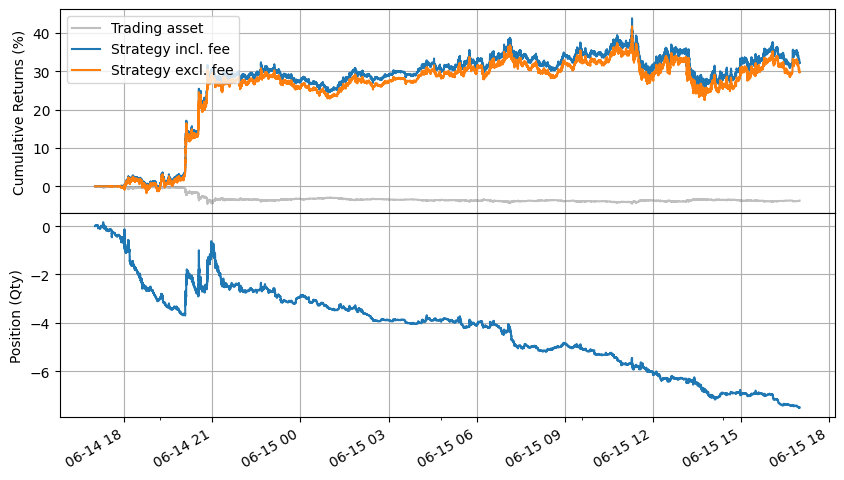

In [7]:
stat.save_summary_to_file(capital=10_000, trading_days=1, name=f'support_resistance_{file_name}')